## 1. Importing libraries

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import json

##2. Importing Data and defining the weights

In [ ]:
input_file = "/content/data-nutri-score-project - Sheet1.csv"
data = pd.read_csv("/content/data-nutri-score-project - Sheet1.csv")
weights_w1 = {
    "Energy (kcal)": 4,
    "Sugars (g)": 3,
    "Saturated Fat (g)": 3,
    "Salt (g)": 3,
    "Proteins (g)": 2,
    "Fiber (g)": 2,
    "Fruits/Vegetables (%)": 1,
}

thresholds = [0.5, 0.55, 0.6]

In [ ]:
data['Nutri-Score'] = data['Nutri-Score'].str.upper()
data['Eco-Score'] = data['Eco-Score'].str.upper()
data.head()

,Product Name,Brand,Category,Nutri-Score,Nutri-Score-Value,Eco-Score,Eco-Score-Value,Energy (kcal),Sugars (g),Saturated Fat (g),Salt (g),Fiber (g),Proteins (g),Fruits/Vegetables (%)
0,cruesly mélange de noix,Quaker,"Aliments et boissons à base de végétaux,Alimen...",A,-6,B,76,462,12,2,0,10,"8,5","10,7"
1,Céréales Chocapic,Nestlé,"Plant-based foods and beverages,Plant-based fo...",A,-2,E,10,388,"22,4",2,"0,22","7,5","8,8",0
2,Flocons d'avoine,Bjorg,"Aliments et boissons à base de végétaux,Alimen...",A,-8,A,84,362,"1,7","1,3","0,02",11,11,0
3,Haferflocken,Crownfield,"Plantaardige levensmiddelen en dranken,Plantaa...",A,-8,A,87,372,"0,7","1,3","0,03",10,"13,5",0
4,Weetabix,Weetabix,"Plant-based foods and beverages, Plant-based f...",A,-6,E,10,362,"4,4","0,6","0,275",10,12,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Product Name           943 non-null    object
 1   Brand                  943 non-null    object
 2   Category               943 non-null    object
 3   Nutri-Score            943 non-null    object
 4   Nutri-Score-Value      943 non-null    int64 
 5   Eco-Score              943 non-null    object
 6   Eco-Score-Value        943 non-null    int64 
 7   Energy (kcal)          943 non-null    object
 8   Sugars (g)             943 non-null    object
 9   Saturated Fat (g)      943 non-null    object
 10  Salt (g)               943 non-null    object
 11  Fiber (g)              943 non-null    object
 12  Proteins (g)           943 non-null    object
 13  Fruits/Vegetables (%)  943 non-null    object
dtypes: int64(2), object(12)
memory usage: 103.3+ KB


In [ ]:
data['Energy (kcal)'] = pd.to_numeric(data['Energy (kcal)'], errors='coerce')
data['Sugars (g)'] = pd.to_numeric(data['Sugars (g)'], errors='coerce')
data['Saturated Fat (g)'] = pd.to_numeric(data['Saturated Fat (g)'], errors='coerce')
data['Salt (g)'] = pd.to_numeric(data['Salt (g)'], errors='coerce')
data['Fiber (g)'] = pd.to_numeric(data['Fiber (g)'], errors='coerce')
data['Proteins (g)'] = pd.to_numeric(data['Proteins (g)'], errors='coerce')
data['Fruits/Vegetables (%)'] = pd.to_numeric(data['Fruits/Vegetables (%)'], errors='coerce')

## 3. Setting the limiting profiles

###3.1 Setting limitting profiles manually

In [ ]:
# Define limiting profiles for Nutri-Score categories (A to E)
limiting_profiles_1 = {
    "A": {"Energy (kcal)": 335, "Sugars (g)": 5, "Saturated Fat (g)": 1, "Salt (g)": 0.1, "Proteins (g)": 8, "Fiber (g)": 10, "Fruits/Vegetables (%)": 40},
    "B": {"Energy (kcal)": 400, "Sugars (g)": 10, "Saturated Fat (g)": 2, "Salt (g)": 0.3, "Proteins (g)": 6, "Fiber (g)": 8, "Fruits/Vegetables (%)": 20},
    "C": {"Energy (kcal)": 500, "Sugars (g)": 15, "Saturated Fat (g)": 3, "Salt (g)": 0.5, "Proteins (g)": 4, "Fiber (g)": 5, "Fruits/Vegetables (%)": 10},
    "D": {"Energy (kcal)": 700, "Sugars (g)": 20, "Saturated Fat (g)": 5, "Salt (g)": 1.0, "Proteins (g)": 2, "Fiber (g)": 3, "Fruits/Vegetables (%)": 5},
    "E": {"Energy (kcal)": 900, "Sugars (g)": 30, "Saturated Fat (g)": 8, "Salt (g)": 2.0, "Proteins (g)": 0, "Fiber (g)": 0, "Fruits/Vegetables (%)": 0},
}

### 3.2. Finding limiting profiles using quintile approach

In [ ]:
#using segmentation approach (quantile approach) to find limiting profiles:
columns_to_min = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]
columns_to_max = ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]

quintiles_min = data[columns_to_min].quantile([0.2, 0.4, 0.6, 0.8])
quintiles_max = data[columns_to_max].quantile([0.2, 0.4, 0.6, 0.8])

print(f"To minimize : \n{quintiles_min}")
print(f"To maximize : \n{quintiles_max}")

To minimize : 
     Energy (kcal)  Sugars (g)  Saturated Fat (g)  Salt (g)
0.2          369.0        13.0                1.0       0.0
0.4          380.0        16.0                2.0       0.0
0.6          401.6        19.0                4.0       0.0
0.8          443.0        23.0                5.0       1.0
To maximize : 
     Proteins (g)  Fiber (g)  Fruits/Vegetables (%)
0.2           8.0        6.0                    0.0
0.4          10.0        8.0                    0.0
0.6          11.0       10.0                    0.0
0.8          13.0       11.0                    3.0


In [ ]:
data[columns_to_max].max().to_dict()

{'Proteins (g)': 80.0, 'Fiber (g)': 33.0, 'Fruits/Vegetables (%)': 70.0}

In [ ]:
limiting_profiles_2 = {
    "A": {**quintiles_min.loc[0.2].to_dict(), **data[columns_to_max].max().to_dict()},  # Min Q1 + Max valeurs
    "B": {**quintiles_min.loc[0.4].to_dict(), **quintiles_max.loc[0.8].to_dict()},     # Min Q2 + Max Q4
    "C": {**quintiles_min.loc[0.6].to_dict(), **quintiles_max.loc[0.6].to_dict()},     # Min Q3 + Max Q3
    "D": {**quintiles_min.loc[0.8].to_dict(), **quintiles_max.loc[0.4].to_dict()},     # Min Q4 + Max Q2
    "E": {**data[columns_to_min].max().to_dict(), **quintiles_max.loc[0.2].to_dict()}  # Max valeurs + Min Q1
}

limiting_profiles_2

{'A': {'Energy (kcal)': 369.0,
  'Sugars (g)': 13.0,
  'Saturated Fat (g)': 1.0,
  'Salt (g)': 0.0,
  'Proteins (g)': 80.0,
  'Fiber (g)': 33.0,
  'Fruits/Vegetables (%)': 70.0},
 'B': {'Energy (kcal)': 380.0,
  'Sugars (g)': 16.0,
  'Saturated Fat (g)': 2.0,
  'Salt (g)': 0.0,
  'Proteins (g)': 13.0,
  'Fiber (g)': 11.0,
  'Fruits/Vegetables (%)': 3.0},
 'C': {'Energy (kcal)': 401.6,
  'Sugars (g)': 19.0,
  'Saturated Fat (g)': 4.0,
  'Salt (g)': 0.0,
  'Proteins (g)': 11.0,
  'Fiber (g)': 10.0,
  'Fruits/Vegetables (%)': 0.0},
 'D': {'Energy (kcal)': 443.0,
  'Sugars (g)': 23.0,
  'Saturated Fat (g)': 5.0,
  'Salt (g)': 1.0,
  'Proteins (g)': 10.0,
  'Fiber (g)': 8.0,
  'Fruits/Vegetables (%)': 0.0},
 'E': {'Energy (kcal)': 601.0,
  'Sugars (g)': 48.0,
  'Saturated Fat (g)': 16.0,
  'Salt (g)': 2.0,
  'Proteins (g)': 8.0,
  'Fiber (g)': 6.0,
  'Fruits/Vegetables (%)': 0.0}}

In [ ]:
df_limit_profiles_2 = pd.DataFrame(limiting_profiles_2)
df_limit_profiles_2

,A,B,C,D,E
Energy (kcal),369.0,380.0,401.6,443.0,601.0
Sugars (g),13.0,16.0,19.0,23.0,48.0
Saturated Fat (g),1.0,2.0,4.0,5.0,16.0
Salt (g),0.0,0.0,0.0,1.0,2.0
Proteins (g),80.0,13.0,11.0,10.0,8.0
Fiber (g),33.0,11.0,10.0,8.0,6.0
Fruits/Vegetables (%),70.0,3.0,0.0,0.0,0.0


### 2.3. Finding limiting profiles using K-means

In [ ]:
def calculate_limiting_profiles(df, num_clusters=5):
    nutritional_features = [
        "Energy (kcal)",
        "Sugars (g)",
        "Saturated Fat (g)",
        "Salt (g)",
        "Proteins (g)",
        "Fiber (g)",
        "Fruits/Vegetables (%)"
    ]
    data = df[nutritional_features].dropna()
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)

    centroids = kmeans.cluster_centers_

    limiting_profiles = pd.DataFrame(
        centroids.T,  # Transpose to have rows as criteria
        index=nutritional_features,
        columns=["A", "B", "C", "D", "E"][:num_clusters]  # Nutri-Score categories as columns
    )

    return limiting_profiles

In [ ]:
limiting_profiles_3 = calculate_limiting_profiles(data)
limiting_profiles_3

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


,A,B,C,D,E
Energy (kcal),0.0,378.0,359.0,0.000000e+00,0.000000e+00
Sugars (g),0.0,1.0,1.0,0.000000e+00,0.000000e+00
Saturated Fat (g),0.0,1.0,1.0,0.000000e+00,0.000000e+00
Salt (g),0.0,0.0,0.0,0.000000e+00,0.000000e+00
Proteins (g),0.0,14.0,14.0,8.881784e-16,8.881784e-16
Fiber (g),0.0,11.0,11.0,0.000000e+00,0.000000e+00
Fruits/Vegetables (%),10.0,0.0,0.0,2.220446e-16,2.220446e-16


### 3.4. Finding limiting profiles using UTA approach (voir notebook UTA_approach.ipynb)

In [ ]:
file_path = "limiting_profiles_uta.json"
with open(file_path, "r") as file:
    limiting_profiles_4 = json.load(file)

limiting_profiles_4

{'A': {'Energy (kcal)': 494.0,
  'Sugars (g)': 25.0,
  'Salt (g)': 1.1,
  'Saturated Fat (g)': 4.8,
  'Proteins (g)': 80.0,
  'Fiber (g)': 27.5,
  'Fruits/Vegetables (%)': 99.796875},
 'B': {'Energy (kcal)': 508.0,
  'Sugars (g)': 27.1,
  'Salt (g)': 1.3075,
  'Saturated Fat (g)': 5.0,
  'Proteins (g)': 22.1,
  'Fiber (g)': 27.0,
  'Fruits/Vegetables (%)': 56.1875},
 'C': {'Energy (kcal)': 524.0,
  'Sugars (g)': 48.0,
  'Salt (g)': 2.0,
  'Saturated Fat (g)': 9.2,
  'Proteins (g)': 27.9,
  'Fiber (g)': 27.0,
  'Fruits/Vegetables (%)': 63.25},
 'D': {'Energy (kcal)': 601.0,
  'Sugars (g)': 39.0,
  'Salt (g)': 1.42,
  'Saturated Fat (g)': 20.7,
  'Proteins (g)': 16.0,
  'Fiber (g)': 14.0,
  'Fruits/Vegetables (%)': 70.0},
 'E': {'Energy (kcal)': 534.0,
  'Sugars (g)': 40.0,
  'Salt (g)': 1.67,
  'Saturated Fat (g)': 16.0,
  'Proteins (g)': 10.0,
  'Fiber (g)': 7.11,
  'Fruits/Vegetables (%)': 3.07161458333333}}

In [ ]:
df_limit_profiles_4 = pd.DataFrame(limiting_profiles_4)
df_limit_profiles_4

,A,B,C,D,E
Energy (kcal),494.000000,508.0000,524.00,601.00,534.000000
Sugars (g),25.000000,27.1000,48.00,39.00,40.000000
Salt (g),1.100000,1.3075,2.00,1.42,1.670000
Saturated Fat (g),4.800000,5.0000,9.20,20.70,16.000000
Proteins (g),80.000000,22.1000,27.90,16.00,10.000000
Fiber (g),27.500000,27.0000,27.00,14.00,7.110000
Fruits/Vegetables (%),99.796875,56.1875,63.25,70.00,3.071615




---


## 4. Pessimistic approch



In [ ]:
def transform_criteria(row):

    transformed_row = row.copy()
    for criterion in row.index:
        if criterion in ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]:  # Minimized
            transformed_row[criterion] = 10 - row[criterion]
        elif criterion in ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]:  # Maximized
            transformed_row[criterion] = 2 * row[criterion]
    return transformed_row

def compute_concordance(item, profile, weights):

    transformed_item = transform_criteria(item)
    concordance = 0
    total_weight = sum(weights.values())
    for criterion, value in profile.items():
        if criterion in ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]:
            # Criteria to maximize
            if transformed_item[criterion] >= value:
                concordance += weights[criterion]
        else:
            # Criteria to minimize
            if transformed_item[criterion] <= value:
                concordance += weights[criterion]
    return concordance / total_weight

def pessimistic_majority_sorting(item, profiles, weights, lambda_threshold):
    for category, profile in sorted(profiles.items()):
        concordance = compute_concordance(item, profile, weights)
        if concordance >= lambda_threshold:
            return category
    return "E"  # Default to the worst category if no match is found

###4.1 Results with limitting profiles set mannualy

In [ ]:
#data = pd.read_excel(input_file)
results = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category = pessimistic_majority_sorting(row, limiting_profiles_1, weights_w1, lambda_value)

        results.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category
        })
df = pd.DataFrame(results)
df

,Product Name,Nutri score,Lambda,Pessimistic Category
0,cruesly mélange de noix,A,0.50,A
1,cruesly mélange de noix,A,0.55,E
2,cruesly mélange de noix,A,0.60,E
3,Céréales Chocapic,A,0.50,E
4,Céréales Chocapic,A,0.55,E
...,...,...,...,...
2824,Bamboo,A,0.55,E
2825,Bamboo,A,0.60,E
2826,Müesli croccante all'avena,C,0.50,A
2827,Müesli croccante all'avena,C,0.55,A


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829 entries, 0 to 2828
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product Name          2829 non-null   object 
 1   Nutri score           2829 non-null   object 
 2   Lambda                2829 non-null   float64
 3   Pessimistic Category  824 non-null    object 
dtypes: float64(1), object(3)
memory usage: 88.5+ KB


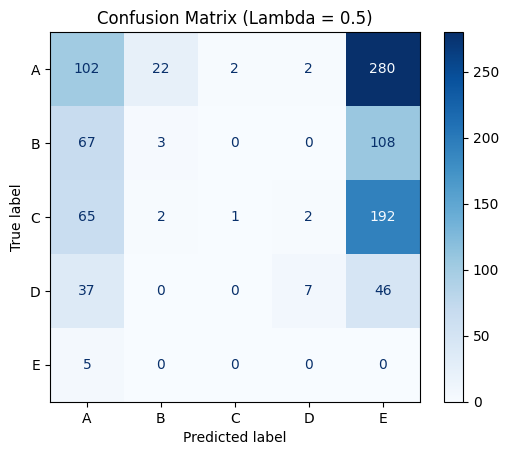

In [ ]:
# Select Lambda value to analyze
lambda_to_analyze = 0.5
subset = df[df["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"]
y_pred = subset["Pessimistic Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()


In [ ]:
# Calculate and print accuracy
accuracy_1 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_1:.2f}")

# Calculate and print precision
precision_1 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_1:.2f}")

# Calculate and print recall
recall_1 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_1:.2f}")

# Calculate and print F1 score
f1 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.12
Precision: 0.29
Recall: 0.07
F1 Score: 0.09


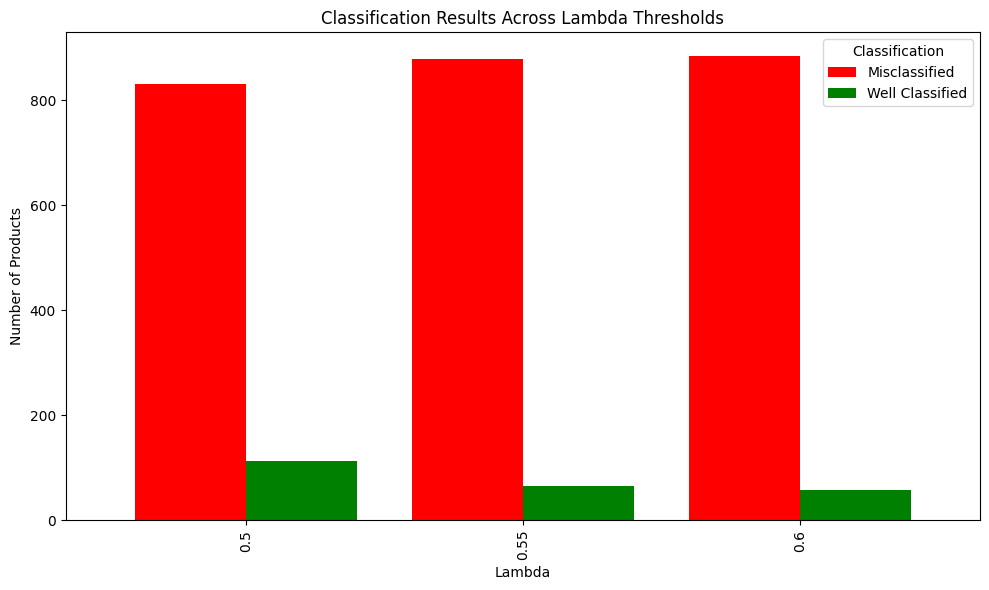

In [ ]:
df['Well Classified'] = df['Nutri score'] == df['Pessimistic Category']
classification_counts = df.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['red', 'green'],
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

### 4.2 Results with limiting profiles found with quantile approach:

In [ ]:
#data = pd.read_excel(input_file)
results_2 = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category_2 = pessimistic_majority_sorting(row, limiting_profiles_2, weights_w1, lambda_value)

        results_2.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category_2
        })

df_2 = pd.DataFrame(results_2)
df_2

,Product Name,Nutri score,Lambda,Pessimistic Category
0,cruesly mélange de noix,A,0.50,B
1,cruesly mélange de noix,A,0.55,E
2,cruesly mélange de noix,A,0.60,E
3,Céréales Chocapic,A,0.50,E
4,Céréales Chocapic,A,0.55,E
...,...,...,...,...
2824,Bamboo,A,0.55,E
2825,Bamboo,A,0.60,E
2826,Müesli croccante all'avena,C,0.50,B
2827,Müesli croccante all'avena,C,0.55,B


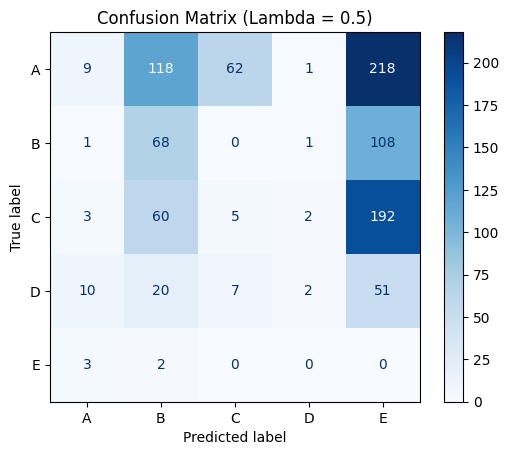

In [ ]:
subset = df_2[df_2["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"]
y_pred = subset["Pessimistic Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()

In [ ]:
# Calculate and print accuracy
accuracy_2 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_2:.2f}")

# Calculate and print precision
precision_2 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_2:.2f}")

# Calculate and print recall
recall_2 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_2:.2f}")

# Calculate and print F1 score
f2 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f2:.2f}")

Accuracy: 0.09
Precision: 0.20
Recall: 0.09
F1 Score: 0.08


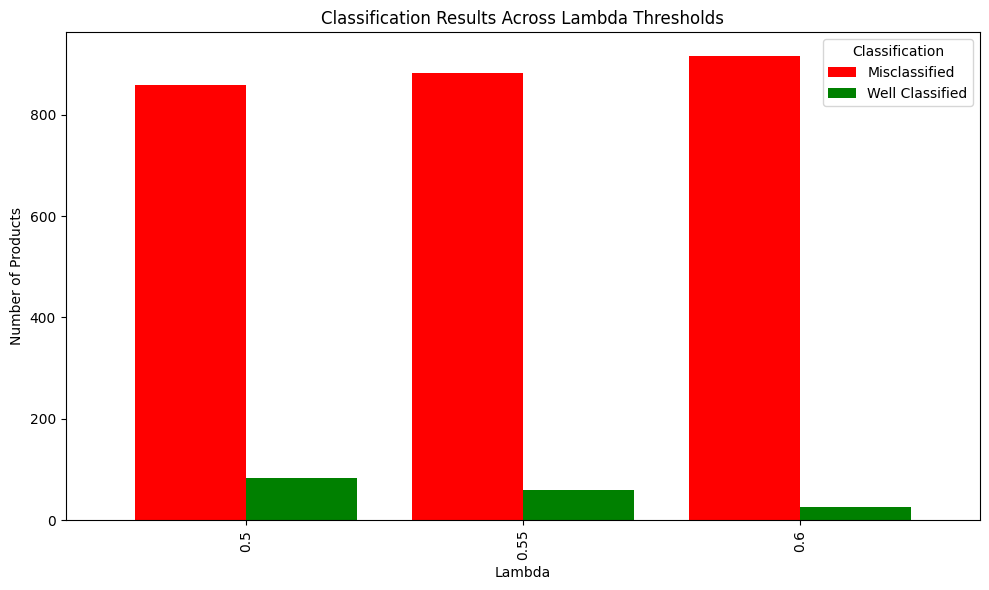

In [ ]:
df_2['Well Classified'] = df_2['Nutri score'] == df_2['Pessimistic Category']
classification_counts = df_2.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['red', 'green'],
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

### 4.3 Limiting profiles found using K-means:

In [ ]:
results_3 = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category_3 = pessimistic_majority_sorting(row, limiting_profiles_3, weights_w1, lambda_value)

        results_3.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category_3
        })

df_3 = pd.DataFrame(results_3)
df_3

,Product Name,Nutri score,Lambda,Pessimistic Category
0,cruesly mélange de noix,A,0.50,A
1,cruesly mélange de noix,A,0.55,E
2,cruesly mélange de noix,A,0.60,E
3,Céréales Chocapic,A,0.50,E
4,Céréales Chocapic,A,0.55,E
...,...,...,...,...
2824,Bamboo,A,0.55,E
2825,Bamboo,A,0.60,E
2826,Müesli croccante all'avena,C,0.50,A
2827,Müesli croccante all'avena,C,0.55,A


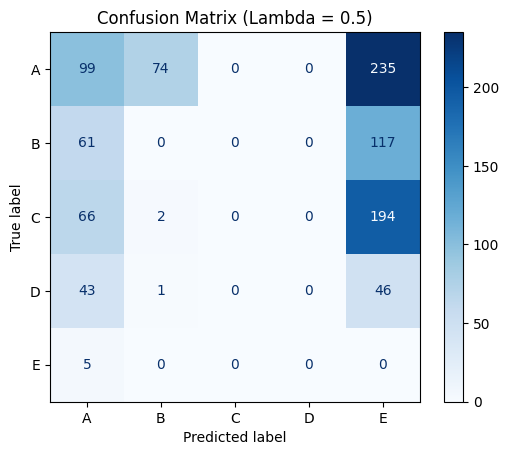

In [ ]:
subset = df_3[df_3["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"].dropna()
y_pred = subset["Pessimistic Category"].dropna()
valid_indices = y_true.notnull() & y_pred.notnull()
y_true = y_true[valid_indices]
y_pred = y_pred[valid_indices]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()

In [ ]:
# Calculate and print accuracy
accuracy_3 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_3:.2f}")

# Calculate and print precision
precision_3 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_3:.2f}")

# Calculate and print recall
recall_3 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_3:.2f}")

# Calculate and print F1 score
f3 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f3:.2f}")

Accuracy: 0.10
Precision: 0.07
Recall: 0.05
F1 Score: 0.06


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


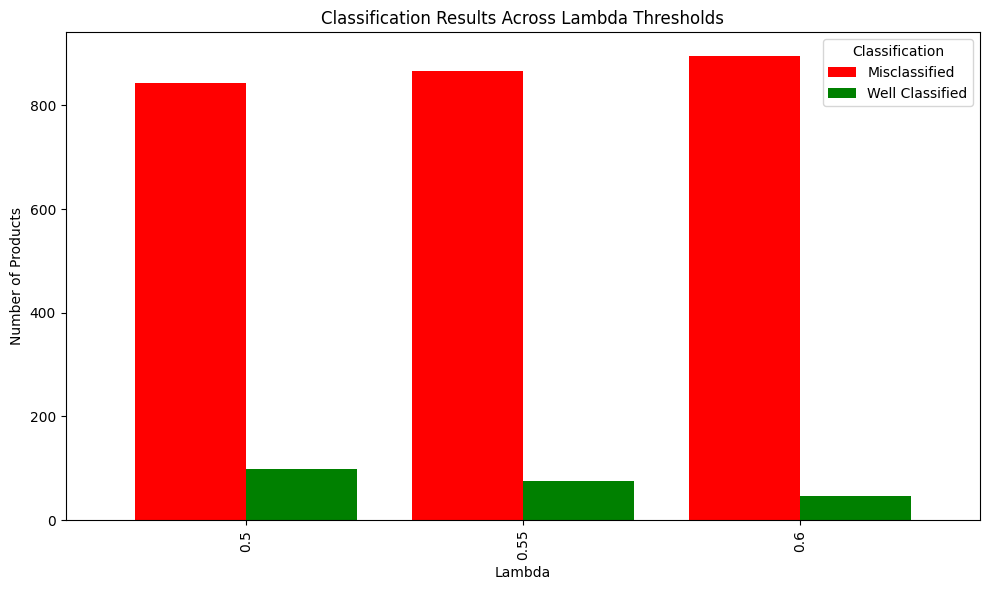

In [ ]:
df_3['Well Classified'] = df_3['Nutri score'] == df_3['Pessimistic Category']
classification_counts = df_3.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['red', 'green'],
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

### 4.4 Limiting profiles found usin UTA approach:

In [ ]:
results_4 = []
for _, row in data.iterrows():
    for lambda_value in thresholds:
        pessimistic_category_4 = pessimistic_majority_sorting(row, limiting_profiles_4, weights_w1, lambda_value)

        results_4.append({
            "Product Name": row["Product Name"],
            "Nutri score": row["Nutri-Score"].upper(),
            "Lambda": lambda_value,
            "Pessimistic Category": pessimistic_category_4
        })

df_4 = pd.DataFrame(results_4)
df_4

,Product Name,Nutri score,Lambda,Pessimistic Category
0,cruesly mélange de noix,A,0.50,C
1,cruesly mélange de noix,A,0.55,C
2,cruesly mélange de noix,A,0.60,D
3,Céréales Chocapic,A,0.50,E
4,Céréales Chocapic,A,0.55,E
...,...,...,...,...
2824,Bamboo,A,0.55,E
2825,Bamboo,A,0.60,E
2826,Müesli croccante all'avena,C,0.50,D
2827,Müesli croccante all'avena,C,0.55,E


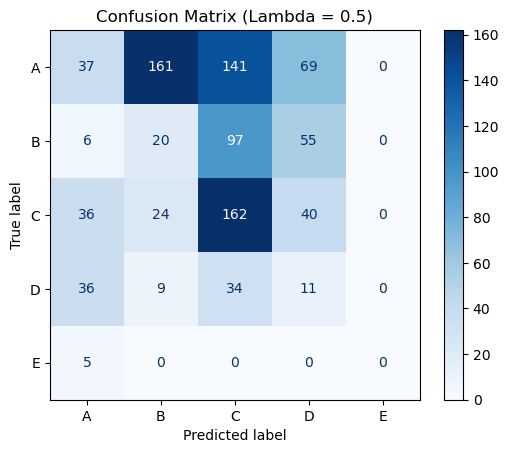

In [ ]:
subset = df_4[df_4["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri score"]
y_pred = subset["Pessimistic Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Lambda = {lambda_to_analyze})")
plt.show()

In [ ]:
# Calculate and print accuracy
accuracy_4 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_4:.2f}")

# Calculate and print precision
precision_4 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_4:.2f}")

# Calculate and print recall
recall_4 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_4:.2f}")

# Calculate and print F1 score
f4 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f4:.2f}")

Accuracy: 0.24
Precision: 0.17
Recall: 0.19
F1 Score: 0.16


/home/melissa/miniconda3/envs/bdma/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


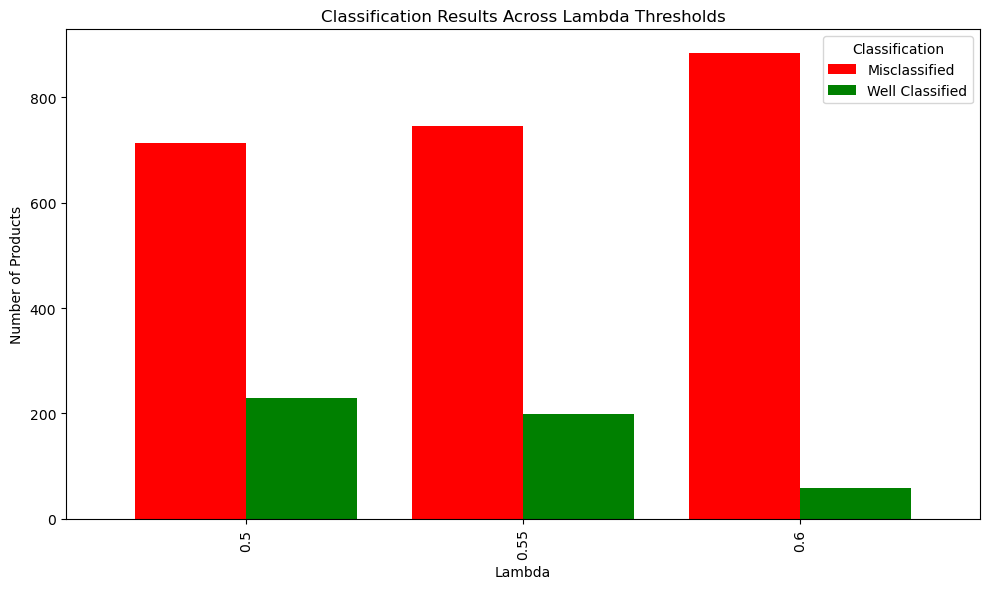

In [ ]:
df_4['Well Classified'] = df_4['Nutri score'] == df_4['Pessimistic Category']
classification_counts = df_4.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['red', 'green'],
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

### 4.5 Performance measures summary

In [ ]:
data_sum = {
    "Limiting profiles - Approach": ['Manually', 'Quintiles', 'K-means', 'UTA'],
    "Accuracy": [accuracy_1, accuracy_2, accuracy_3, accuracy_4],
    "Precision": [precision_1, precision_2, precision_3, precision_4],
    "Recall": [recall_1, recall_2, recall_3, recall_4],
    "F1 Score": [f1, f2, f3, f4],
}
performance_df = pd.DataFrame(data_sum)
performance_df

,Limiting profiles - Approach,Accuracy,Precision,Recall,F1 Score
0,Manually,0.275716,0.076817,0.133785,0.096535
1,Quintiles,0.206787,0.420555,0.213565,0.106030
2,K-means,0.434505,0.120672,0.200646,0.123690
3,UTA,0.243902,0.167584,0.188718,0.158146




---
## 5. Optimistic approch


In [ ]:
def optimistic_majority_sorting(data, weights, limiting_profiles, lambda_values):
    # Normalize data based on criteria type
    criteria_to_minimize = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)"]
    for col in criteria_to_minimize:
        data[col] = 10 - data[col]

    criteria_to_maximize = ["Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]
    for col in criteria_to_maximize:
        data[col] = 2 * data[col]

    # Prepare profiles in a structured format
    relevant_columns = ["Energy (kcal)", "Sugars (g)", "Saturated Fat (g)", "Salt (g)", "Proteins (g)", "Fiber (g)", "Fruits/Vegetables (%)"]
    profiles = {k: np.array([v[c] for c in relevant_columns]) for k, v in limiting_profiles.items()}

    # Compute concordance indices
    def concordance(a, b, weights):
      concordance_sum = 0
      for i, criterion in enumerate(relevant_columns): #iterate by index and criteria name
        if a[i] >= b[i]: # compare using index
             concordance_sum += weights[criterion] # access weights using criterion name
      return concordance_sum


    # Assign categories using the optimistic approach
    def assign_category(food, profiles, lambda_threshold, weights):
        total_weight = sum(weights.values())
        for category, profile in profiles.items():
            if concordance(food, profile, weights) / total_weight >= lambda_threshold:
                return category
        return "A"  # Default to the worst category if no match is found

    # Process each food item for each lambda value
    results = []
    for lambda_threshold in lambda_values: #loop through each lambda value
        for _, row in data.iterrows():
            food_name = row["Product Name"]  # Assuming "Food Name" column exists
            nutri_score = row["Nutri-Score"]  # Keep the Nutri-Score column
            food = row[relevant_columns].values
            category = assign_category(food, profiles, lambda_threshold, weights)
            results.append({"Product Name": food_name, "Nutri-Score": nutri_score, "Category": category, "Lambda": lambda_threshold})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    return results_df

### 5.1 Results with limitting profiles set mannualy

In [ ]:
results_1 = optimistic_majority_sorting(data, weights_w1, limiting_profiles_1, thresholds)

In [ ]:
df_optimistic_1 = pd.DataFrame(results_1)

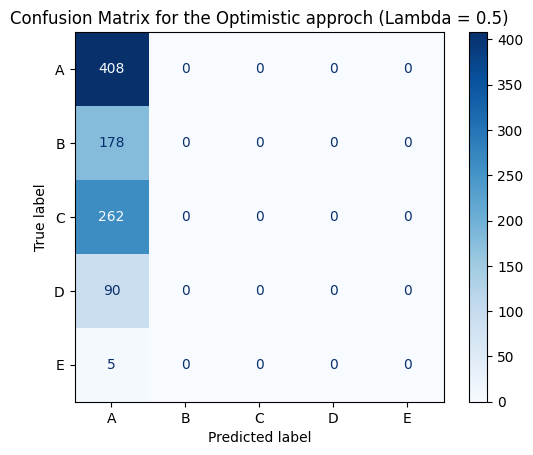

In [ ]:
# Select Lambda value to analyze
lambda_to_analyze = 0.5
subset = df_optimistic_1[df_optimistic_1["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri-Score"]
y_pred = subset["Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for the Optimistic approch (Lambda = {lambda_to_analyze})")
plt.show()

In [ ]:
# Calculate and print accuracy
accuracy_1 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_1:.2f}")

# Calculate and print precision
precision_1 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_1:.2f}")

# Calculate and print recall
recall_1 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_1:.2f}")

# Calculate and print F1 score
f1 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f3:.2f}")

Accuracy: 0.43
Precision: 0.09
Recall: 0.20
F1 Score: 0.12


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


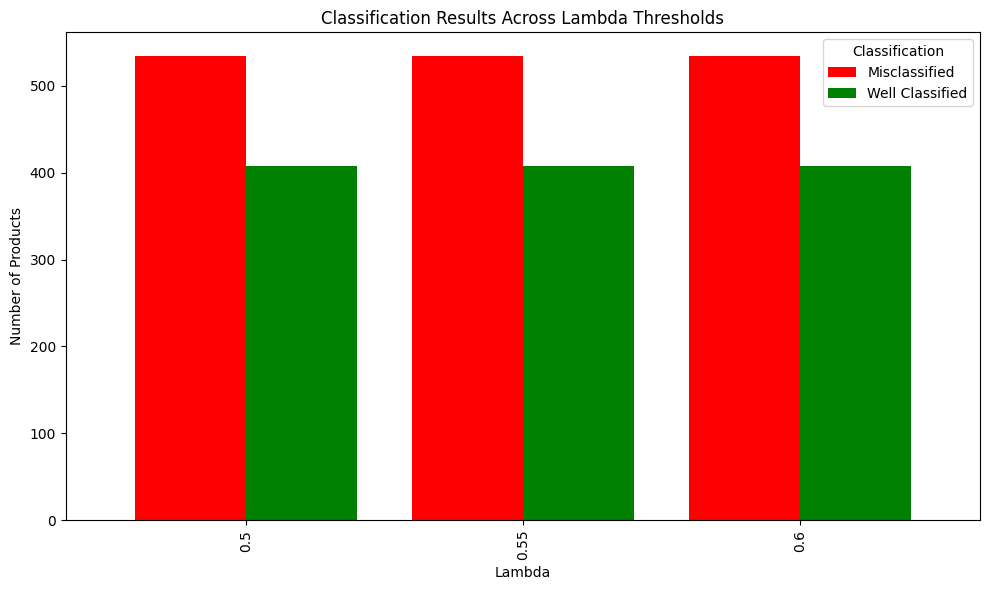

In [ ]:
df_optimistic_1['Well Classified'] = df_optimistic_1['Nutri-Score'] == df_optimistic_1['Category']
classification_counts = df_optimistic_1.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['red', 'green'],
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

### 5.2 Results with limitting profiles foud with quantile approach

In [ ]:
results_2 = optimistic_majority_sorting(data, weights_w1, limiting_profiles_2, thresholds)

In [ ]:
df_optimistic_2 = pd.DataFrame(results_2)

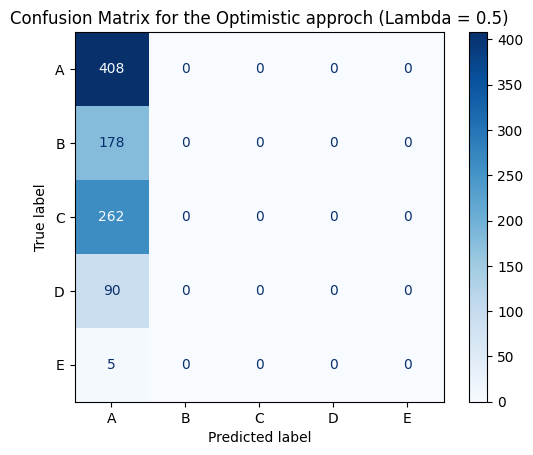

In [ ]:
# Select Lambda value to analyze
lambda_to_analyze = 0.5
subset = df_optimistic_2[df_optimistic_2["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri-Score"]
y_pred = subset["Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for the Optimistic approch (Lambda = {lambda_to_analyze})")
plt.show()

In [ ]:
# Calculate and print accuracy
accuracy_2 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_2:.2f}")

# Calculate and print precision
precision_2 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_2:.2f}")

# Calculate and print recall
recall_2 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_2:.2f}")

# Calculate and print F1 score
f2 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f2:.2f}")

Accuracy: 0.43
Precision: 0.09
Recall: 0.20
F1 Score: 0.12


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


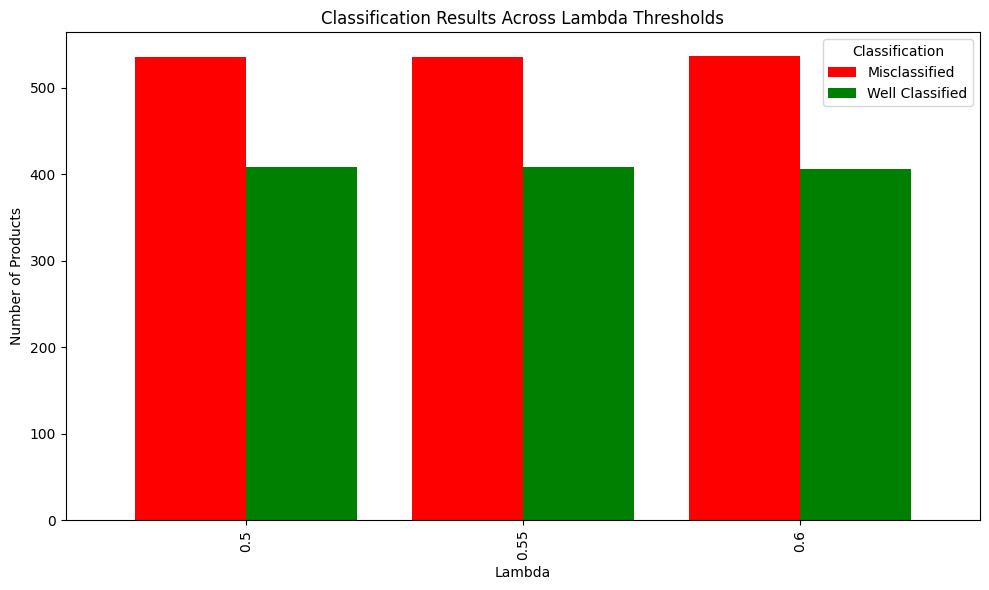

In [ ]:
df_optimistic_2['Well Classified'] = df_optimistic_2['Nutri-Score'] == df_optimistic_2['Category']
classification_counts = df_optimistic_2.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['red', 'green'],
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

### 5.3 Results with limitting profiles found using K-mean

In [ ]:
results_3 = optimistic_majority_sorting(data, weights_w1, limiting_profiles_3, thresholds)

In [ ]:
df_optimistic_3 = pd.DataFrame(results_3)

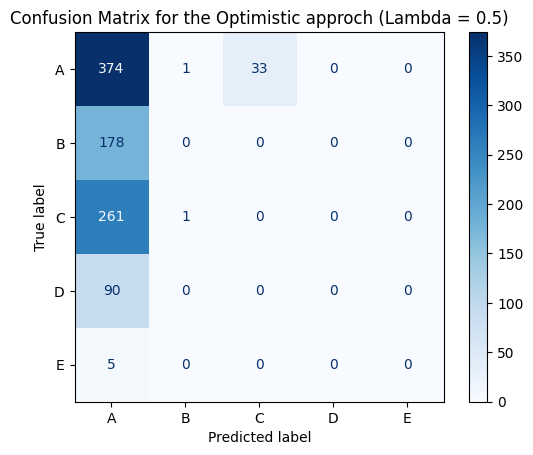

In [ ]:
# Select Lambda value to analyze
lambda_to_analyze = 0.5
subset = df_optimistic_3[df_optimistic_3["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri-Score"]
y_pred = subset["Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for the Optimistic approch (Lambda = {lambda_to_analyze})")
plt.show()

In [ ]:
# Calculate and print accuracy
accuracy_3 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_3:.2f}")

# Calculate and print precision
precision_3 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_3:.2f}")

# Calculate and print recall
recall_3 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_3:.2f}")

# Calculate and print F1 score
f3 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f3:.2f}")

Accuracy: 0.40
Precision: 0.08
Recall: 0.18
F1 Score: 0.11


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


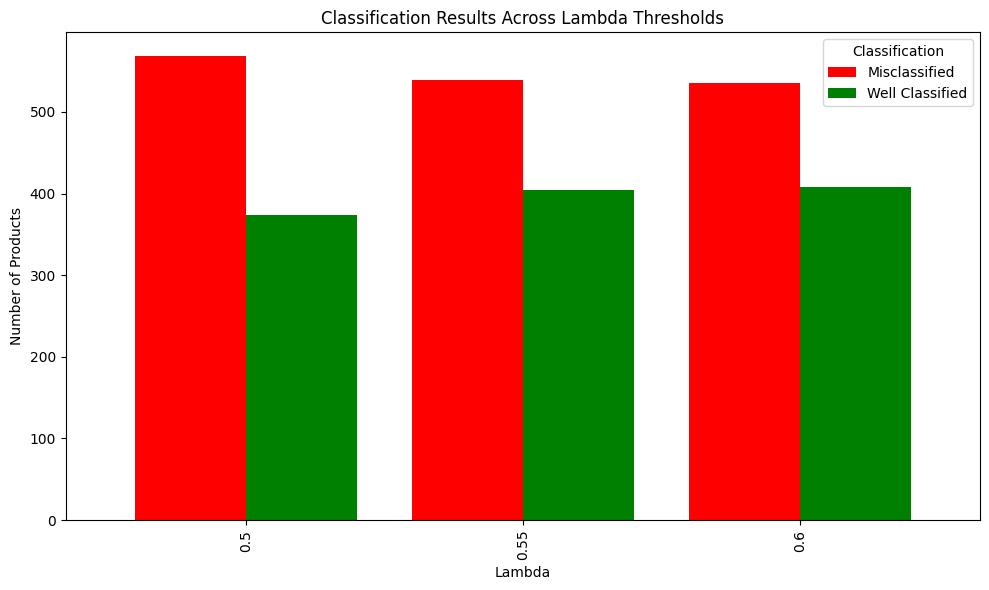

In [ ]:
df_optimistic_3['Well Classified'] = df_optimistic_3['Nutri-Score'] == df_optimistic_3['Category']
classification_counts = df_optimistic_3.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['red', 'green'],
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

### 5.4 Results with limitting profiles using UTA

In [ ]:
results_4 = optimistic_majority_sorting(data, weights_w1, limiting_profiles_4, thresholds)

In [ ]:
df_optimistic_4 = pd.DataFrame(results_4)

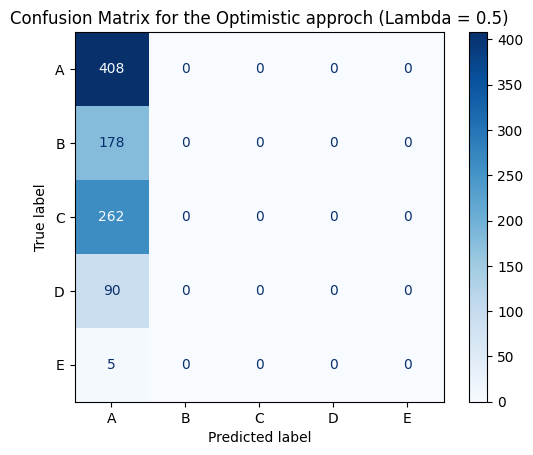

In [ ]:
# Select Lambda value to analyze
lambda_to_analyze = 0.5
subset = df_optimistic_4[df_optimistic_4["Lambda"] == lambda_to_analyze]
y_true = subset["Nutri-Score"]
y_pred = subset["Category"]

cm = confusion_matrix(y_true, y_pred, labels=["A", "B", "C", "D", "E"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["A", "B", "C", "D", "E"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for the Optimistic approch (Lambda = {lambda_to_analyze})")
plt.show()

In [ ]:
# Calculate and print accuracy
accuracy_4 = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy_4:.2f}")

# Calculate and print precision
precision_4 = precision_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Precision: {precision_4:.2f}")

# Calculate and print recall
recall_4 = recall_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"Recall: {recall_4:.2f}")

# Calculate and print F1 score
f4 = f1_score(y_true, y_pred, labels=["A", "B", "C", "D", "E"], average='macro')  # Adjust 'macro' as needed
print(f"F1 Score: {f4:.2f}")

Accuracy: 0.43
Precision: 0.09
Recall: 0.20
F1 Score: 0.12


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


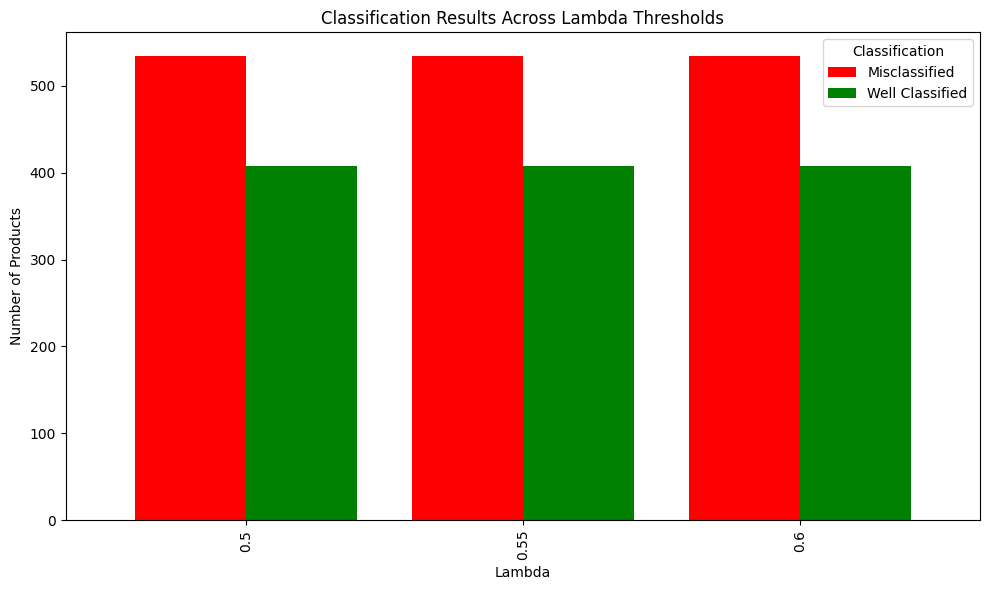

In [ ]:
df_optimistic_4['Well Classified'] = df_optimistic_4['Nutri-Score'] == df_optimistic_4['Category']
classification_counts = df_optimistic_4.groupby('Lambda')['Well Classified'].value_counts().unstack(fill_value=0)

ax = classification_counts.plot(
    kind='bar',
    stacked=False,
    figsize=(10, 6),
    color=['red', 'green'],
    width=0.8
)

plt.title('Classification Results Across Lambda Thresholds')
plt.xlabel('Lambda')
plt.ylabel('Number of Products')
plt.legend(['Misclassified', 'Well Classified'], title='Classification')
plt.tight_layout()

plt.show()

### 5.5 Performance measures summary:

In [ ]:
data_sum = {
    "Limiting profiles - Approach": ['Manually', 'Quintiles', 'K-means', 'UTA'],
    "Accuracy": [accuracy_1, accuracy_2, accuracy_3, accuracy_4],
    "Precision": [precision_1, precision_2, precision_3, precision_4],
    "Recall": [recall_1, recall_2, recall_3, recall_4],
    "F1 Score": [f1, f2, f3, f4],
}
performance_df = pd.DataFrame(data_sum)
performance_df

,Limiting profiles - Approach,Accuracy,Precision,Recall,F1 Score
0,Manually,0.432662,0.086532,0.200000,0.120799
1,Quintiles,0.432662,0.086532,0.200000,0.120799
2,K-means,0.396607,0.082379,0.183333,0.113678
3,UTA,0.432662,0.086532,0.200000,0.120799
